## Imports

In [1]:
import os
from PIL import Image
from glob import glob
import scipy.misc
from scipy.misc import imread, imresize
from random import randrange, randint, uniform
import math 
%matplotlib inline

import numpy as np
import pandas as pd

In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
# from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image
# from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Reshape, Activation
from keras.layers.core import Lambda
from keras.layers.pooling import MaxPool2D
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


## Data

In [3]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'data')
ori_dir = os.path.join(data_dir, 'ori')
ori_csv = os.path.join(ori_dir, 'orientations.csv')

In [4]:
os.chdir(ori_dir)
img_size = 128
img_dim = 3
num = 359
test = 1
files = sorted(glob("*.png"))
x = np.asarray([imresize(imread(file,mode='RGB'), (img_size,img_size)) for file in files[:num]])
x_test = np.asarray([imresize(imread(file,mode='RGB'), (img_size,img_size)) for file in files[num:num+test]])
df = pd.read_csv(ori_csv,delimiter=',')
os.chdir(base_dir)

/home/nathan/anaconda3/envs/DL-Keras/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/nathan/anaconda3/envs/DL-Keras/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/nathan/anaconda3/envs/DL-Keras/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/nathan/anaconda3/envs/DL-Keras/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [5]:
df['roomba_rad'] = np.deg2rad(df['roomba_rotation'])
df['roomba_xhat'] = np.cos(df['roomba_rad'])
df['roomba_yhat'] = np.sin(df['roomba_rad'])

In [6]:
y = df[:num][['roomba_xhat', 'roomba_yhat']].values
y_test = df[num:num+test][['roomba_xhat', 'roomba_yhat']].values

## Model

### Choose layers

#### Mobilenet

In [7]:
output_num = 2
mobilenet = MobileNet(input_shape=(img_size,img_size,img_dim),
                      alpha=1.00,
                      depth_multiplier=1,
                      dropout=1e-3,
                      include_top=False,
                      weights='imagenet',
                      input_tensor=None,
                      pooling='avg',
                      classes=1000)
mobile_layers = mobilenet.layers
final_layers = [Reshape((1, 1, -1), name='reshape_1'),
                Dropout(.05, name='dropout'),
#                 Conv2D(output_num, (1, 1), padding='same', name='conv_preds'),
                Dense(256, activation='relu', name='dense_1'),
                Dropout(.05, name='dropout_2'),
                Dense(2, name='dense_2'),
                Activation('linear', name='act_linear'),
                Reshape((output_num,), name='reshape_2')]

layers = mobile_layers + final_layers
n = 5
for layer in layers[:-n]:
    layer.trainable = False
for layer in layers[-n:]:
    layer.trainable = True

#### VGG16

In [8]:
# vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
# vgg_preprocess = lambda x: (x - vgg_mean)[:, ::-1]
# vgg16 = VGG16(include_top=True, weights='imagenet', pooling=None, input_shape=(224,224,3))
# layers = [vgg16.layers[0]] + [Lambda(vgg_preprocess)] + vgg16.layers[1:-1] + [Dense(2, activation='relu')]

# model = Sequential(layers=layers)
# for layer in model.layers[:-2]:
#     layer.trainable = False
# for layer in model.layers[-2:]:
#     layer.trainable = True
# model.summary()

#### Custom

In [9]:
# layers = [Conv2D(16, (3,3), padding='same', input_shape=(128,128,3)),
#           BatchNormalization(),
#           Activation('relu'),
#           MaxPool2D((2, 2), strides=(2, 2)),
          
#           Conv2D(16, (3,3), padding='same'),
#           BatchNormalization(),
#           Activation('relu'),
#           MaxPool2D((2, 2), strides=(2, 2)),
          
#           Conv2D(16, (3,3), padding='same'),
#           BatchNormalization(),
#           Activation('relu'),
#           MaxPool2D((2, 2), strides=(2, 2)),
          
#           Conv2D(16, (3,3), padding='same'),
#           BatchNormalization(),
#           Activation('relu'),
#           MaxPool2D((2, 2), strides=(2, 2)),
          
#           Flatten(),
#           Dense(1024),
#           BatchNormalization(),
#           Activation('relu'),
# #           Dropout(.5),
          
#           Dense(2),
#          ]

### Make model

In [10]:
model = Sequential(layers)
opt = Adam(lr=.001)
model.compile(optimizer=opt,loss='mean_squared_error')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

## Train

In [12]:
model.fit(x, y, batch_size=32, epochs=10, validation_split=.0)

Epoch 1/10
359/359 [==============================] - 1s 3ms/step - loss: 1.7850
Epoch 2/10
359/359 [==============================] - 0s 879us/step - loss: 0.3685
Epoch 3/10
359/359 [==============================] - 0s 905us/step - loss: 0.2757
Epoch 4/10
359/359 [==============================] - 0s 882us/step - loss: 0.1308
Epoch 5/10
359/359 [==============================] - 0s 896us/step - loss: 0.0876
Epoch 6/10
359/359 [==============================] - 0s 849us/step - loss: 0.0770
Epoch 7/10
359/359 [==============================] - 0s 848us/step - loss: 0.0740
Epoch 8/10
359/359 [==============================] - 0s 838us/step - loss: 0.0717
Epoch 9/10
359/359 [==============================] - 0s 844us/step - loss: 0.0619
Epoch 10/10
359/359 [==============================] - 0s 880us/step - loss: 0.0612


In [13]:
# for layer in model.layers:
#     layer.trainable = True
opt = Adam(lr=.0001)
model.compile(optimizer=opt,loss='mean_squared_error')

In [14]:
model.fit(x, y, batch_size=32, epochs=3, validation_split=.0)

Epoch 1/3
359/359 [==============================] - 1s 1ms/step - loss: 0.0570
Epoch 2/3
359/359 [==============================] - 0s 862us/step - loss: 0.0522
Epoch 3/3
359/359 [==============================] - 0s 827us/step - loss: 0.0475


## Test

In [15]:
def vecToAngle(vec):
    return np.degrees(np.arctan2(vec[1], vec[0]))

In [16]:
y_pred = model.predict(x_test)

True Angle -1.0
Pred Angle -17.3778


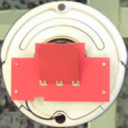

In [17]:
# n = 61
# n = 82
n = np.random.randint(test)
img = Image.fromarray(x_test[n])
print("True Angle", vecToAngle(y_test[n]))
print("Pred Angle", vecToAngle(y_pred[n]))
img

In [18]:
y_pred.mean(axis=0)

array([ 0.74789989, -0.23405965], dtype=float32)

In [19]:
print(y_pred.mean(), y_pred.std())

0.25692 0.49098


## Export

In [20]:
model.save('mobilenet_finetune.hdf5')